# Histograms with specific countries highlighted

This notebook is primarily for creating the plots used in the country dossiers of the UBA project for which this code was originally produced. 

It allows the user to highlight a country of interest within the distribution. 

In [1]:
# import modules needed for the code to run

# system 
import re
import os

# calculation
import pandas as pd
import numpy as np

# plotting
%matplotlib inline
import seaborn
import matplotlib

# global stocktake tools
from gst_tools.make_plots import *
import gst_tools.gst_utils as utils


In [2]:
# USER INPUT

# First, choose which file you want to plot the data for
#data_file_name = 'UN-population-data-2017.csv'
#data_file_name = 'PRIMAP-hist_v2.0_Energy-CO2.csv'
#data_file_name = 'PRIMAP-hist_v2.0_IPPU-KyotoGHG.csv'
data_file_name = 'PRIMAP-hist_UN-2017_calc__CO2-per-population.csv'
#data_file_name = 'WDI2017_GDP-PPP.csv'

# Second, choose which years you are interested in analysing
years_of_interest = ['2014']

# selected country - ISO3 country code of the country that you would like to highlight
countries_of_interest = ['IND', 'MEX', 'VNM', 'ETH']

In [3]:
# DATA READING AND PREP

# read the data from file 
fname_in = os.path.join('proc-data', data_file_name)
data = pd.read_csv(fname_in)

# Check the data format
if not utils.verify_data_format(data):
    print('WARNING: The data is not correctly formatted! Please check before continuing!')

# extract the key information
variable = data['variable'].unique()[0]
unit = data['unit'].unique()[0]

# tidy up for next stesps
data_years = utils.set_countries_as_index(data)
data_years = data_years.dropna(axis=0, how='any')

# remove comment below to display the data
#data_years

IND
-----------
Identifying and removing outliers
lower outliers are:
Series([], Name: 2014, dtype: float64)
upper outliers are: 
country
ARE    26.348088
BHR    22.897388
BRN    21.690341
KWT    22.842338
QAT    44.221344
TTO    33.887218
Name: 2014, dtype: float64
---


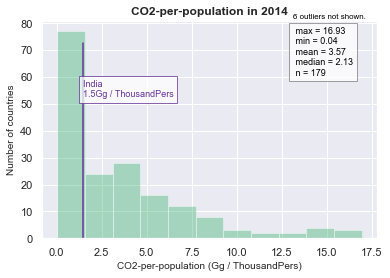

MEX
-----------
Identifying and removing outliers
lower outliers are:
Series([], Name: 2014, dtype: float64)
upper outliers are: 
country
ARE    26.348088
BHR    22.897388
BRN    21.690341
KWT    22.842338
QAT    44.221344
TTO    33.887218
Name: 2014, dtype: float64
---


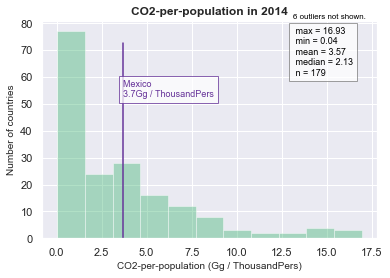

VNM
-----------
Identifying and removing outliers
lower outliers are:
Series([], Name: 2014, dtype: float64)
upper outliers are: 
country
ARE    26.348088
BHR    22.897388
BRN    21.690341
KWT    22.842338
QAT    44.221344
TTO    33.887218
Name: 2014, dtype: float64
---


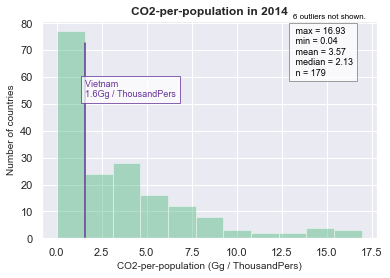

ETH
-----------
Identifying and removing outliers
lower outliers are:
Series([], Name: 2014, dtype: float64)
upper outliers are: 
country
ARE    26.348088
BHR    22.897388
BRN    21.690341
KWT    22.842338
QAT    44.221344
TTO    33.887218
Name: 2014, dtype: float64
---


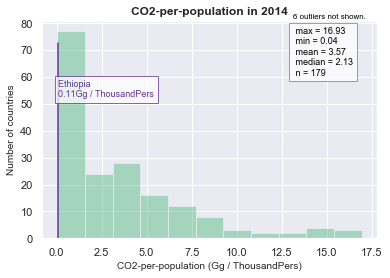

In [4]:
# Plot 1 - make a histogram of absolute data

for this_country in countries_of_interest:
    print(this_country)
    for selected_year in years_of_interest:
        make_histogram(data_years[selected_year], variable, unit, 
                   remove_outliers=True, 
                   save_plot=False, 
                   selected_country=this_country)


Averaging trend over 5 years.
-----------
Identifying and removing outliers
lower outliers are:
Series([], Name: 2015, dtype: float64)
upper outliers are: 
country
MOZ    31.367723
NIU    31.461331
Name: 2015, dtype: float64
---
bins set to range(-18, 18, 2)


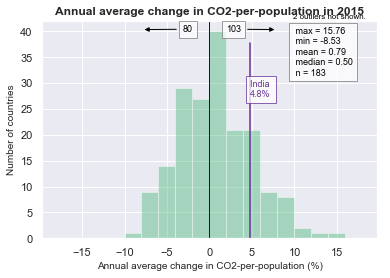

-----------
Identifying and removing outliers
lower outliers are:
Series([], Name: 2015, dtype: float64)
upper outliers are: 
country
MOZ    31.367723
NIU    31.461331
Name: 2015, dtype: float64
---
bins set to range(-18, 18, 2)


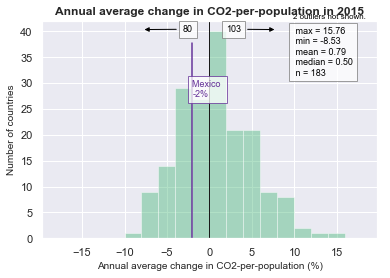

-----------
Identifying and removing outliers
lower outliers are:
Series([], Name: 2015, dtype: float64)
upper outliers are: 
country
MOZ    31.367723
NIU    31.461331
Name: 2015, dtype: float64
---
bins set to range(-18, 18, 2)


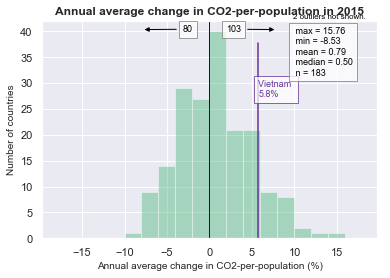

-----------
Identifying and removing outliers
lower outliers are:
Series([], Name: 2015, dtype: float64)
upper outliers are: 
country
MOZ    31.367723
NIU    31.461331
Name: 2015, dtype: float64
---
bins set to range(-18, 18, 2)


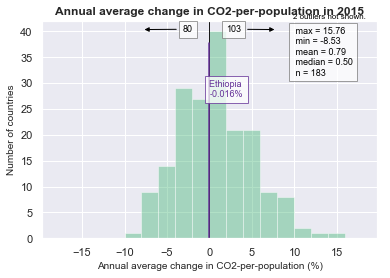

In [5]:
# Plot 2 - trends

# Calculate trends and define plotting params    
# TODO - improve description here. 
trends, rolling_trends, trends_unit = utils.calculate_trends(data_years, num_years_trend=5)
trends_variable = 'Annual average change in ' + variable

# plot the trend in the final year
for this_country in countries_of_interest:
    make_histogram(rolling_trends.iloc[:,-1], trends_variable, 
               trends_unit, 
               remove_outliers=True,
               selected_country=this_country,
               save_plot=False)


Code for testing

In [12]:
rolling_trends['2014']


country
AFG     8.908899
AGO     0.934782
ALB     4.644740
ARE     2.331891
ARG     1.137404
ARM     6.064507
ATG    -0.051923
AUS    -2.241865
AUT    -2.496003
AZE     1.049168
BDI    14.951123
BEL    -3.367741
BEN     4.130438
BFA     7.158289
BGD     5.208331
BGR     0.464269
BHR    -0.200595
BHS     7.879404
BIH     3.905259
BLR    -0.304917
BLZ    -4.799028
BOL     6.214147
BRA     5.393221
BRB    -4.535806
BRN     2.387645
BWA    12.041854
CAF     3.420736
CAN    -0.187036
CHE    -3.231527
CHL     3.744337
         ...    
STP     2.198377
SUR    -0.285578
SVK    -3.308699
SVN    -4.258785
SWE    -3.590142
SWZ     1.194929
SYR   -11.900825
TCD    -2.817592
TGO    -3.607677
THA     3.151769
TJK    10.979809
TKM     3.008445
TON    -1.752117
TTO     0.188390
TUN     1.928828
TUR     0.252212
TUV     2.436078
UKR    -0.644605
URY    -1.950078
USA    -0.631137
UZB    -4.221915
VCT    -5.789180
VEN    -0.599100
VNM     4.443555
VUT     4.326515
WSM     3.115822
YEM    -7.024549
ZAF   